<a href="https://colab.research.google.com/github/AD-26/Speech-Emotion-Recognition/blob/main/SER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa soundfile scikit-learn numpy matplotlib seaborn


In [ ]:
!pip install soundfile librosa scikit-learn streamlit pyngrok --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.2 MB/s eta 0:00:00


In [ ]:
!pip install tqdm

In [ ]:
!pip install tensorflow

In [ ]:


import os
import librosa
import soundfile
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


In [ ]:
import os
import librosa
import numpy as np
import soundfile as sf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from google.colab import files


In [ ]:
import numpy as np
import pandas as pd
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.utils import to_categorical


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
data_dir = "/content/drive/MyDrive/Speech/datasets/"


Mounted at /content/drive


In [ ]:
def extract_features(file_path):
    try:
        X, sample_rate = soundfile.read(file_path)
        if X.ndim > 1:
            X = np.mean(X, axis=1)
        mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
        chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
        mel = librosa.feature.melspectrogram(y=X, sr=sample_rate)
        return np.hstack((
            np.mean(mfccs.T, axis=0),
            np.mean(chroma.T, axis=0),
            np.mean(mel.T, axis=0)
        ))
    except Exception as e:
        print(f"❌ Error in {file_path}: {e}")
        return None




In [ ]:
def get_label_from_path(file_path):
    fname = os.path.basename(file_path).lower()
    emotions_map = {
        'angry': 'angry',
        'calm': 'calm',
        'disgust': 'disgust',
        'fear': 'fear',
        'happy': 'happy',
        'neutral': 'neutral',
        'ps': 'ps',  # pleasant surprise


    }
    for keyword, emotion in emotions_map.items():
        if keyword in fname:
            return emotion
    return 'unknown'

X, y = [], []

for root, dirs, files in os.walk(data_dir):
    for file in tqdm(files):
        if file.endswith(".wav"):
            path = os.path.join(root, file)
            label = get_label_from_path(path)
            if label != 'unknown':
                features = extract_features(path)
                if features is not None:
                    X.append(features)
                    y.append(label)


X = np.array(X)
y = np.array(y)

np.save("/content/drive/MyDrive/Speech/X_features.npy", X)
np.save("/content/drive/MyDrive/Speech/y_labels.npy", y)

print("✅ Saved: X_features.npy and y_labels.npy")



0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 535/535 [00:00<00:00, 175254.03it/s]
0it [00:00, ?it/s]
100%|██████████| 210/210 [00:15<00:00, 13.15it/s]
0it [00:00, ?it/s]
100%|██████████| 200/200 [00:08<00:00, 22.70it/s]


✅ Saved: X_features.npy and y_labels.npy


In [ ]:
def load_audio_files(base_path):
    features, labels = [], []
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                label = get_label_from_path(file_path)
                feature = extract_features(file_path)
                if feature is not None and label != 'unknown':
                    features.append(feature)
                    labels.append(label)
    return np.array(features), np.array(labels)

data_dir = '/content/drive/MyDrive/Speech/datasets'
X, y = load_audio_files(data_dir)
print(f"✅ Loaded: {len(X)} samples with shape {X.shape}")
print("🎯 Emotions:", set(y))


✅ Loaded: 4824 samples with shape (4824, 180)
🎯 Emotions: {np.str_('disgust'), np.str_('ps'), np.str_('neutral'), np.str_('happy'), np.str_('angry'), np.str_('calm'), np.str_('fear')}


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf_model = RandomForestClassifier(random_state=42)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid.fit(X, y_encoded)

print(f"🎯 Best Accuracy: {grid.best_score_:.4f}")
print("🛠️ Best Parameters:", grid.best_params_)

best_model = grid.best_estimator_


🎯 Best Accuracy: 0.9988
🛠️ Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

       angry       1.00      1.00      1.00       148
        calm       1.00      1.00      1.00         5
     disgust       1.00      1.00      1.00       173
        fear       1.00      1.00      1.00       130
       happy       1.00      1.00      1.00       174
     neutral       1.00      1.00      1.00       187
          ps       1.00      1.00      1.00       148

    accuracy                           1.00       965
   macro avg       1.00      1.00      1.00       965
weighted avg       1.00      1.00      1.00       965



In [ ]:


def predict_emotion(file_path):
    try:
        features = extract_features(file_path)
        features = features.reshape(1, -1)
        prediction = best_model.predict(features)
        return le.inverse_transform(prediction)[0]
    except Exception as e:
        print("❌ Error predicting emotion:", str(e))
        return None


In [ ]:
labels = []  # string labels like 'happy', 'sad', etc.


In [ ]:
test_file = "/content/drive/MyDrive/Speech/datasets/RAVDESS/Actor_24/03-01-08-02-02-02-24.wav"
emotion = predict_emotion(test_file)
print("🎙️ Predicted Emotion:", emotion)


🎙️ Predicted Emotion: ps


In [ ]:
import joblib
joblib.dump(best_model, "/content/drive/MyDrive/Speech/best_rf_model.pkl")
joblib.dump(le, "/content/drive/MyDrive/Speech/label_encoder.pkl")


['/content/drive/MyDrive/Speech/label_encoder.pkl']

In [ ]:
import joblib

model = joblib.load("/content/drive/MyDrive/Speech/best_rf_model.pkl")
label_encoder = joblib.load("/content/drive/MyDrive/Speech/label_encoder.pkl")

def predict_emotion_saved_model(filepath):
    feature = extract_features(filepath)
    if feature is None:
        return "❌ Couldn't extract features"
    feature = feature.reshape(1, -1)
    prediction = model.predict(feature)
    return label_encoder.inverse_transform(prediction)[0]


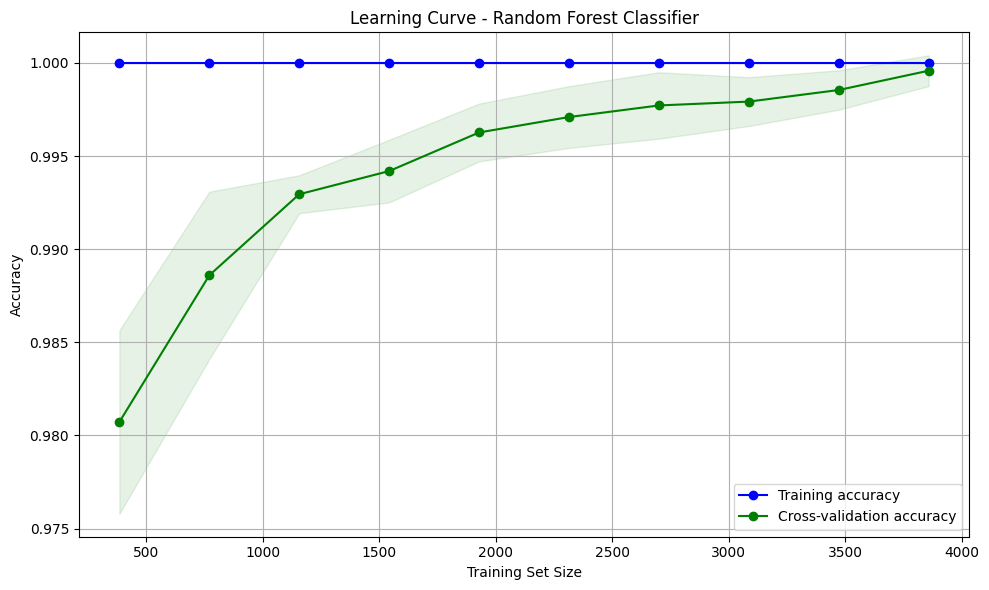

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np


model = best_model

# learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    model, X, y_encoded,
    cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)


train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes, val_mean, 'o-', color='green', label='Cross-validation accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='green')

plt.title('Learning Curve - Random Forest Classifier')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.tight_layout()
plt.show()


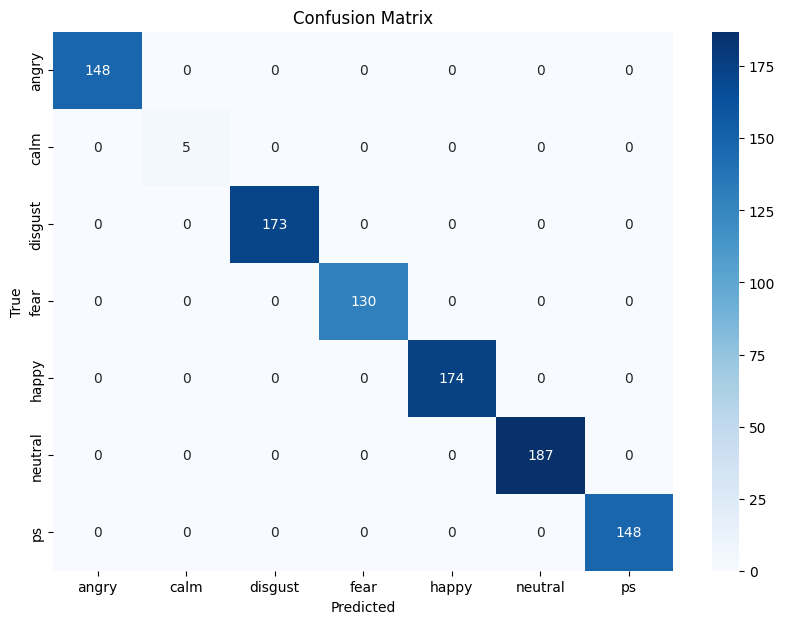

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, xticklabels=le.classes_, yticklabels=le.classes_, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:


from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

svm_pipeline = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=10, gamma='scale')
)


calibrated_svm = CalibratedClassifierCV(estimator=svm_pipeline, cv=5)
calibrated_svm.fit(X_train, y_train)


joblib.dump(calibrated_svm, "/content/drive/MyDrive/Speech/best_svm_model.pkl")


['/content/drive/MyDrive/Speech/best_svm_model.pkl']

In [ ]:
import numpy as np
import librosa
import os
import joblib
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint


X = np.load("/content/drive/MyDrive/Speech/X_features.npy")
y = np.load("/content/drive/MyDrive/Speech/y_labels.npy")

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

joblib.dump(le, "/content/drive/MyDrive/Speech/label_encoder.pkl")

X_reshaped = np.expand_dims(X, axis=1)

model = Sequential([
    LSTM(128, return_sequences=False, input_shape=(1, X.shape[1])),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


checkpoint = ModelCheckpoint("/content/drive/MyDrive/Speech/best_lstm_model.h5", save_best_only=True, monitor='val_loss')
model.fit(X_reshaped, y_cat, epochs=50, batch_size=32, validation_split=0.2, callbacks=[checkpoint])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3925 - loss: 1.6029

121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.3941 - loss: 1.5996 - val_accuracy: 0.9803 - val_loss: 0.2735
Epoch 2/50
118/121 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9010 - loss: 0.3987

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9019 - loss: 0.3956 - val_accuracy: 0.9845 - val_loss: 0.0926
Epoch 3/50
115/121 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9561 - loss: 0.1854

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9566 - loss: 0.1837 - val_accuracy: 0.9917 - val_loss: 0.0571
Epoch 4/50
113/121 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9767 - loss: 0.1088

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9768 - loss: 0.1089 - val_accuracy: 0.9917 - val_loss: 0.0431
Epoch 5/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9768 - loss: 0.0969

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9768 - loss: 0.0969 - val_accuracy: 0.9927 - val_loss: 0.0391
Epoch 6/50
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9860 - loss: 0.0618

121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9859 - loss: 0.0621 - val_accuracy: 0.9917 - val_loss: 0.0365
Epoch 7/50
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9868 - loss: 0.0698

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9868 - loss: 0.0697 - val_accuracy: 0.9948 - val_loss: 0.0300
Epoch 8/50
114/121 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9840 - loss: 0.0718

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9840 - loss: 0.0716 - val_accuracy: 0.9948 - val_loss: 0.0271
Epoch 9/50
116/121 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9850 - loss: 0.0613

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9852 - loss: 0.0611 - val_accuracy: 0.9948 - val_loss: 0.0264
Epoch 10/50
111/121 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9881 - loss: 0.0590

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9883 - loss: 0.0586 - val_accuracy: 0.9948 - val_loss: 0.0248
Epoch 11/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9891 - loss: 0.0434 - val_accuracy: 0.9927 - val_loss: 0.0272
Epoch 12/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9892 - loss: 0.0518 - val_accuracy: 0.9948 - val_loss: 0.0249
Epoch 13/50
115/121 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9880 - loss: 0.0598

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9882 - loss: 0.0587 - val_accuracy: 0.9948 - val_loss: 0.0223
Epoch 14/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9848 - loss: 0.0616 - val_accuracy: 0.9948 - val_loss: 0.0236
Epoch 15/50
116/121 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9937 - loss: 0.0403

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9937 - loss: 0.0404 - val_accuracy: 0.9948 - val_loss: 0.0199
Epoch 16/50
117/121 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9920 - loss: 0.0414

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9920 - loss: 0.0414 - val_accuracy: 0.9959 - val_loss: 0.0179
Epoch 17/50
119/121 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9848 - loss: 0.0593

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9849 - loss: 0.0590 - val_accuracy: 0.9959 - val_loss: 0.0160
Epoch 18/50
117/121 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9930 - loss: 0.0316

121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9930 - loss: 0.0317 - val_accuracy: 0.9959 - val_loss: 0.0138
Epoch 19/50
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9902 - loss: 0.0444

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9902 - loss: 0.0443 - val_accuracy: 0.9969 - val_loss: 0.0132
Epoch 20/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9915 - loss: 0.0398

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9915 - loss: 0.0397 - val_accuracy: 0.9959 - val_loss: 0.0119
Epoch 21/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9920 - loss: 0.0357 - val_accuracy: 0.9959 - val_loss: 0.0123
Epoch 22/50
112/121 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9908 - loss: 0.0349

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9910 - loss: 0.0347 - val_accuracy: 0.9969 - val_loss: 0.0106
Epoch 23/50
114/121 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9949 - loss: 0.0220

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9948 - loss: 0.0224 - val_accuracy: 0.9969 - val_loss: 0.0086
Epoch 24/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9910 - loss: 0.0333 - val_accuracy: 0.9969 - val_loss: 0.0109
Epoch 25/50
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9922 - loss: 0.0282

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9922 - loss: 0.0282 - val_accuracy: 0.9969 - val_loss: 0.0082
Epoch 26/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9906 - loss: 0.0338 - val_accuracy: 0.9969 - val_loss: 0.0130
Epoch 27/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9948 - loss: 0.0226 - val_accuracy: 0.9959 - val_loss: 0.0108
Epoch 28/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9961 - loss: 0.0201 - val_accuracy: 0.9979 - val_loss: 0.0097
Epoch 29/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9931 - loss: 0.0260 - val_accuracy: 0.9959 - val_loss: 0.0094
Epoch 30/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9932 - loss: 0.0271 - val_accuracy: 0.9979 - val_loss: 0.0117
Epoch 31/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9918 - loss: 0.0346 - val_accuracy: 0.9969 - val_loss: 0.0129
Epoch 32/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9925 - loss: 0.0304 - val_accuracy: 0.9

121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9922 - loss: 0.0249 - val_accuracy: 0.9979 - val_loss: 0.0077
Epoch 34/50
115/121 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9909 - loss: 0.0314

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9909 - loss: 0.0314 - val_accuracy: 0.9979 - val_loss: 0.0063
Epoch 35/50
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9931 - loss: 0.0255

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9931 - loss: 0.0255 - val_accuracy: 0.9969 - val_loss: 0.0055
Epoch 36/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9931 - loss: 0.0212 - val_accuracy: 0.9969 - val_loss: 0.0075
Epoch 37/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9942 - loss: 0.0234 - val_accuracy: 0.9969 - val_loss: 0.0084
Epoch 38/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9943 - loss: 0.0204 - val_accuracy: 0.9979 - val_loss: 0.0056
Epoch 39/50
114/121 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9950 - loss: 0.0193

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9949 - loss: 0.0195 - val_accuracy: 0.9969 - val_loss: 0.0049
Epoch 40/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9937 - loss: 0.0233 - val_accuracy: 0.9979 - val_loss: 0.0070
Epoch 41/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9957 - loss: 0.0153 - val_accuracy: 0.9959 - val_loss: 0.0093
Epoch 42/50
116/121 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9930 - loss: 0.0316

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9930 - loss: 0.0315 - val_accuracy: 0.9979 - val_loss: 0.0043
Epoch 43/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9933 - loss: 0.0207 - val_accuracy: 0.9979 - val_loss: 0.0051
Epoch 44/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9947 - loss: 0.0202 - val_accuracy: 0.9969 - val_loss: 0.0116
Epoch 45/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9881 - loss: 0.0415 - val_accuracy: 0.9979 - val_loss: 0.0055
Epoch 46/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9914 - loss: 0.0302 - val_accuracy: 0.9979 - val_loss: 0.0088
Epoch 47/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9909 - loss: 0.0381 - val_accuracy: 0.9979 - val_loss: 0.0049
Epoch 48/50
120/121 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9971 - loss: 0.0149

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9971 - loss: 0.0150 - val_accuracy: 0.9990 - val_loss: 0.0030
Epoch 49/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9914 - loss: 0.0280 - val_accuracy: 0.9969 - val_loss: 0.0079
Epoch 50/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9951 - loss: 0.0215 - val_accuracy: 0.9990 - val_loss: 0.0038


In [ ]:
import numpy as np
import pandas as pd
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.utils import to_categorical


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [ ]:
results = []

# Random Forest
rf = RandomForestClassifier()
start = time.time()
rf.fit(X_train, y_train)
end = time.time()
y_pred_rf = rf.predict(X_test)
results.append({
    "Model": "Random Forest",
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf, average='weighted'),
    "Recall": recall_score(y_test, y_pred_rf, average='weighted'),
    "F1-Score": f1_score(y_test, y_pred_rf, average='weighted'),
    "Training Time": "Fast",

})

# SVM
svm = SVC(probability=True)
start = time.time()
svm.fit(X_train, y_train)
end = time.time()
y_pred_svm = svm.predict(X_test)
results.append({
    "Model": "SVM",
    "Accuracy": accuracy_score(y_test, y_pred_svm),
    "Precision": precision_score(y_test, y_pred_svm, average='weighted'),
    "Recall": recall_score(y_test, y_pred_svm, average='weighted'),
    "F1-Score": f1_score(y_test, y_pred_svm, average='weighted'),
    "Training Time": "Moderate",

})

# LSTM (needs reshaping)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

model = Sequential()
model.add(LSTM(128, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(len(np.unique(y)), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

start = time.time()
history = model.fit(X_train_lstm, y_train_cat, epochs=10, batch_size=32, verbose=0)
end = time.time()

y_pred_lstm = model.predict(X_test_lstm)
y_pred_lstm_labels = np.argmax(y_pred_lstm, axis=1)

results.append({
    "Model": "LSTM",
    "Accuracy": accuracy_score(y_test, y_pred_lstm_labels),
    "Precision": precision_score(y_test, y_pred_lstm_labels, average='weighted'),
    "Recall": recall_score(y_test, y_pred_lstm_labels, average='weighted'),
    "F1-Score": f1_score(y_test, y_pred_lstm_labels, average='weighted'),
    "Training Time": "Slow",

})


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
df_results = pd.DataFrame(results)
df_results["Accuracy"] = (df_results["Accuracy"] * 100).round(2).astype(str) + "%"
df_results = df_results.round(2)
df_results


,Model,Accuracy,Precision,Recall,F1-Score,Training Time
0,Random Forest,100.0%,1.00,1.00,1.00,Fast
1,SVM,94.72%,0.94,0.95,0.94,Moderate
2,LSTM,99.48%,0.99,0.99,0.99,Slow


In [ ]:
!pip install streamlit pyngrok --quiet


In [ ]:
!pip install seaborn


In [ ]:
%%writefile app.py
import streamlit as st
import joblib
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
from tempfile import NamedTemporaryFile
from tensorflow.keras.models import load_model
from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os

# Load label encoder and models
label_encoder = joblib.load("/content/drive/MyDrive/Speech/label_encoder.pkl")
try:
    rf_model = joblib.load("/content/drive/MyDrive/Speech/best_rf_model.pkl")
    svm_model = joblib.load("/content/drive/MyDrive/Speech/best_svm_model.pkl")
    lstm_model = load_model("/content/drive/MyDrive/Speech/best_lstm_model.h5")
except Exception as e:
    st.error("🔴 Error loading model: " + str(e))
    st.stop()

# Extract features
def extract_features(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=None)
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr).T, axis=0)
        mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sr).T, axis=0)
        features = np.hstack([mfccs, chroma, mel])
        return features
    except Exception as e:
        st.error(f"❌ Feature extraction error: {e}")
        return None

# Visualization
def plot_waveform(audio, sr):
    fig, ax = plt.subplots(figsize=(10, 3))
    librosa.display.waveshow(audio, sr=sr, ax=ax)
    ax.set_title("Waveform")
    st.pyplot(fig)

def plot_spectrogram(audio, sr):
    X = librosa.stft(audio)
    Xdb = librosa.amplitude_to_db(abs(X))
    fig, ax = plt.subplots(figsize=(10, 4))
    img = librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', ax=ax)
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    ax.set_title("Spectrogram")
    st.pyplot(fig)

emotion_descriptions = {
    "angry": "Loud, sharp, high-pitched",
    "happy": "Cheerful, energetic tone",
    "sad": "Low energy, slower speech",
    "fear": "Tense, shaky voice",
    "neutral": "Flat, steady tone",
    "calm": "Soft and smooth",
    "disgust": "Rough, annoyed tone",
    "boredom": "Monotone, dull",
    "ps": "Excited, surprised tone"
}

# Streamlit UI
st.title("🎤 Speech Emotion Recognition - RF vs SVM vs LSTM")

uploaded_file = st.file_uploader("📂 Upload a WAV file", type=["wav"])
if uploaded_file is not None:
    with NamedTemporaryFile(delete=False, suffix=".wav") as temp_file:
        temp_file.write(uploaded_file.read())
        file_path = temp_file.name

    st.audio(file_path)

    audio, sr = librosa.load(file_path, sr=None)
    vis = st.radio("🎨 Visualize", ["Waveform", "Spectrogram"])
    st.subheader(f"📈 {vis}")
    plot_waveform(audio, sr) if vis == "Waveform" else plot_spectrogram(audio, sr)

    features = extract_features(file_path)
    if features is not None:
        features = features.reshape(1, -1)

        # Predictions
        rf_probs = rf_model.predict_proba(features)[0]
        rf_pred = label_encoder.inverse_transform([np.argmax(rf_probs)])[0]

        svm_probs = svm_model.predict_proba(features)[0]
        svm_pred = label_encoder.inverse_transform([np.argmax(svm_probs)])[0]

        lstm_input = features.reshape(1, 1, -1)
        lstm_probs = lstm_model.predict(lstm_input)[0]
        lstm_pred = label_encoder.inverse_transform([np.argmax(lstm_probs)])[0]

        # Display predictions
        st.subheader("🎯 Model Predictions")
        col1, col2, col3 = st.columns(3)
        with col1:
            st.markdown("🌲 *Random Forest*")
            st.success(f"{rf_pred} ({rf_probs.max():.2f})")
            st.bar_chart({label_encoder.inverse_transform([i])[0]: rf_probs[i] for i in range(len(rf_probs))})
        with col2:
            st.markdown("📐 *SVM*")
            st.info(f"{svm_pred} ({svm_probs.max():.2f})")
            st.bar_chart({label_encoder.inverse_transform([i])[0]: svm_probs[i] for i in range(len(svm_probs))})
        with col3:
            st.markdown("🧠 *LSTM*")
            st.warning(f"{lstm_pred} ({lstm_probs.max():.2f})")
            st.bar_chart({label_encoder.inverse_transform([i])[0]: lstm_probs[i] for i in range(len(lstm_probs))})

        # Voting
        weights = {rf_pred: 0.82, svm_pred: 0.86, lstm_pred: 0.90}
        vote_total = defaultdict(float)
        for pred, w in weights.items():
            vote_total[pred] += w
        final_vote = max(vote_total.items(), key=lambda x: x[1])[0]
        st.subheader("🧠 Final Suggestion")
        st.info(f"🏆 Weighted Prediction: {final_vote}")

        with st.expander("ℹ Why models differ?"):
            st.markdown("""
            - Different models use different patterns for prediction.
            - Background noise, pitch, or speed may confuse one model but not others.
            - Ensemble (voting) helps average out model biases.
            """)

        # Dummy performance metrics
        def get_metrics(true, pred):
            return {
                "Accuracy": accuracy_score(true, pred),
                "Precision": precision_score(true, pred, average='weighted', zero_division=0),
                "Recall": recall_score(true, pred, average='weighted', zero_division=0),
                "F1-Score": f1_score(true, pred, average='weighted', zero_division=0)
            }

        y_true = ['happy', 'sad', 'angry', 'neutral', 'calm']
        y_rf = ['happy', 'sad', 'angry', 'happy', 'calm']
        y_svm = ['happy', 'neutral', 'angry', 'neutral', 'sad']
        y_lstm = ['happy', 'sad', 'calm', 'neutral', 'calm']

        rf_metrics = get_metrics(y_true, y_rf)
        svm_metrics = get_metrics(y_true, y_svm)
        lstm_metrics = get_metrics(y_true, y_lstm)

        df_metrics = pd.DataFrame([rf_metrics, svm_metrics, lstm_metrics],
                                  index=["Random Forest", "SVM", "LSTM"])
        st.subheader("📊 Model Performance Summary (Demo Data)")
        st.dataframe(df_metrics.round(2))

        st.subheader("🗣 Emotion Descriptions")
        for emo, desc in emotion_descriptions.items():
            st.markdown(f"- *{emo.capitalize()}*: {desc}")
    else:
        st.error("Couldn't extract features from the audio.")




Overwriting app.py


In [ ]:
!pip install streamlit soundfile pyngrok


In [ ]:

!streamlit run app.py &>/content/log.txt &


In [ ]:
!ngrok config add-authtoken 2vJQyIRU6lcm6gQCyzxgO72SDXd_6b3x9XEFfwmBEwj4zyCRv


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok


!pkill streamlit

!kill $(ps aux | grep streamlit | awk '{print $2}') &> /dev/null
!kill $(ps aux | grep ngrok | awk '{print $2}') &> /dev/null



!streamlit run app.py &> /dev/null &


public_url = ngrok.connect("http://localhost:8501")
print("👇 Click the link below to open your app:")
print(public_url)
!streamlit run app.py --server.enableCORS false --server.enableXsrfProtection false &


👇 Click the link below to open your app:
NgrokTunnel: "https://c2cb-34-125-27-250.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8502
  Network URL: http://172.28.0.12:8502
  External URL: http://34.125.27.250:8502

